In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import tensorflow as tf
import keras
import numpy as np
import cv2
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from numpy.random import seed

In [2]:
# Reading the data
path = '../input/skin-cancer-mnist-ham10000/'
images_path = {os.path.splitext(os.path.basename(x))[0]:x for x in glob.glob(os.path.join(path,'*','*.jpg'))}

In [3]:
# Encoding target values
lesion_type_dict = {
    'nv':'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
    
}

In [4]:
skin_df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')


In [5]:
# Adding extra columns and appending the required created columns in final dataframe
skin_df['path'] = skin_df['image_id'].map(images_path.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [6]:
# Image Reading and Resizing.
IMAGE_SIZE = 64
def read_img(img_path):
  img = cv2.imread(img_path,cv2.IMREAD_COLOR)
  img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))
  return img
train_img = []
for img_name in tqdm(skin_df['path'].values):
  train_img.append(read_img(img_name))

100%|██████████| 10015/10015 [03:31<00:00, 47.36it/s]


In [7]:
# Converting it into float arrays and normalizing it
X = np.array(train_img,np.float32)/255
X=X[1:]
print(X.shape)
y = np.array(skin_df['cell_type_idx'])
y=y[1:]

(10014, 64, 64, 3)


In [8]:
# Splitting the data
from sklearn.model_selection import train_test_split

train_df ,test_df,train_labl ,test_labl = train_test_split(X,y,test_size=0.2,random_state=42)



In [9]:
test_labl.shape

(2003,)

In [10]:
train_labl.shape

(8011,)

In [11]:
def build_model(hp):
    # create model object
    model = keras.Sequential([
    #adding first convolutional layer    
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=16, max_value=128, step=16),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        #activation function
        activation='relu',
        input_shape=(64,64,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2)),
    # adding second convolutional layer 
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        #activation function
        activation='relu'
    ),
    tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_2_filter', min_value=4, max_value=128, step=16),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        #activation function
        activation='relu'
    ),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    
    # adding flatten layer    
    keras.layers.Flatten(),
    # adding dense layer    
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=4, max_value=128, step=16),
        activation='relu'
    ),
    # output layer    
    keras.layers.Dense(7, activation='softmax')
    ])
    #compilation of model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-5])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [12]:
#importing random search
from kerastuner import RandomSearch
#creating randomsearch object
tuner = RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials = 50)
# search best parameter
tuner.search(train_df,train_labl,epochs=3,validation_data=(test_df,test_labl))

Trial 50 Complete [00h 01m 25s]
val_accuracy: 0.6630054712295532

Best val_accuracy So Far: 0.6944583058357239
Total elapsed time: 02h 39m 15s


In [41]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dense_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 128, 'step': 16, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 1e-05], 'ordered': True}


In [42]:
model=tuner.get_best_models(num_models=1)[0]
#summary of best model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 48)        3648      
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 48)        192       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 128)       153728    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 128)         4

In [43]:
from keras.utils.vis_utils import plot_model

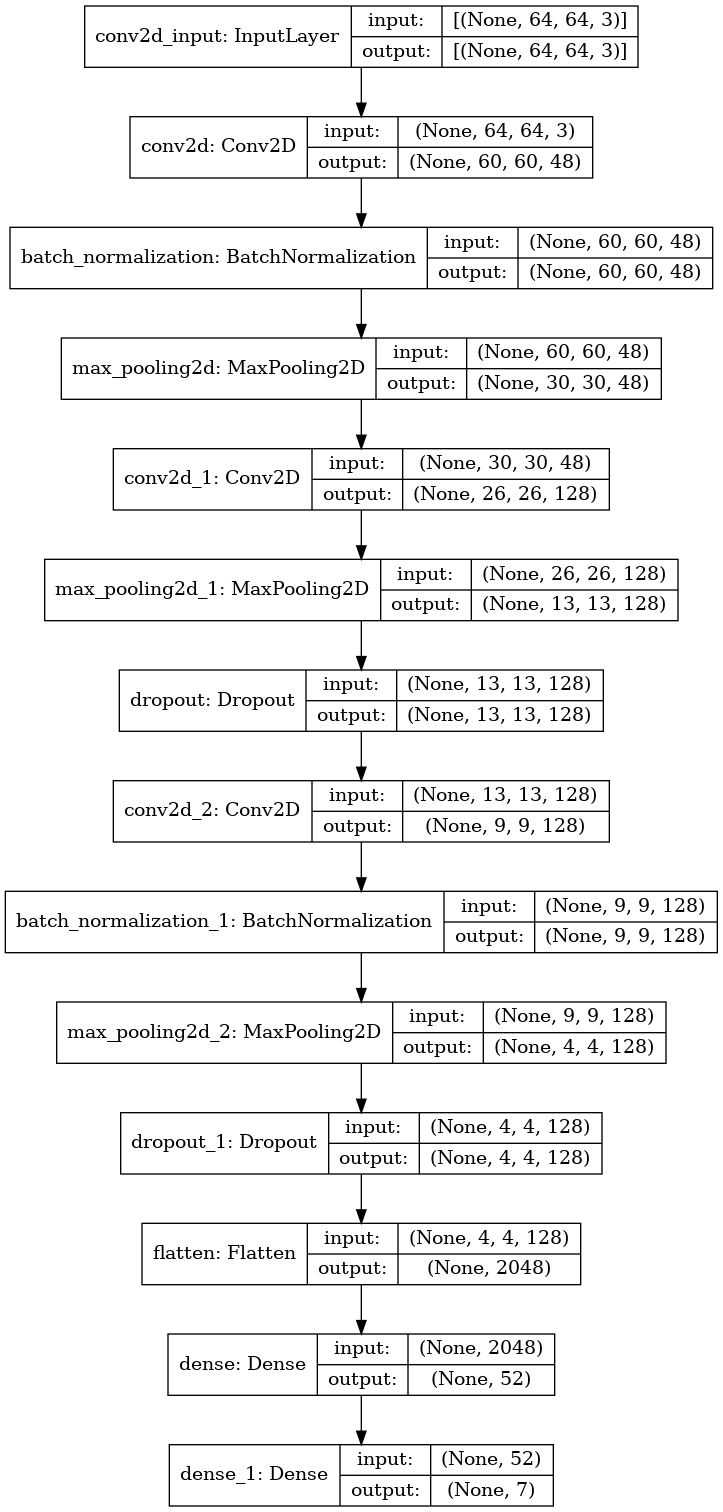

In [44]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [45]:
# !pip install visualkeras


In [46]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv_1_filter: 48
conv_1_kernel: 5
conv_2_filter: 128
conv_2_kernel: 5
dense_1_units: 52
learning_rate: 1e-05
Score: 0.6944583058357239
Trial summary
Hyperparameters:
conv_1_filter: 112
conv_1_kernel: 5
conv_2_filter: 128
conv_2_kernel: 5
dense_1_units: 68
learning_rate: 1e-05
Score: 0.6909635663032532
Trial summary
Hyperparameters:
conv_1_filter: 112
conv_1_kernel: 3
conv_2_filter: 96
conv_2_kernel: 5
dense_1_units: 36
learning_rate: 1e-05
Score: 0.6879680752754211
Trial summary
Hyperparameters:
conv_1_filter: 64
conv_1_kernel: 5
conv_2_filter: 96
conv_2_kernel: 5
dense_1_units: 116
learning_rate: 1e-05
Score: 0.686969518661499
Trial summary
Hyperparameters:
conv_1_filter: 80
conv_1_kernel: 3
conv_2_filter: 112
conv_2_kernel: 5
dense_1_units: 52
learning_rate: 1e-05
Score: 0.6829755306243896
Trial summary
Hyperparameters:
conv_1_filter: 11

In [47]:
checkpoint_filepath = "weights.best_tuner.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [48]:
history=model.fit(train_df,train_labl,
          epochs=100,
          validation_split=0.20,callbacks=[reduce_lr,model_checkpoint_callback])

Epoch 1/100
201/201 [==============================] - 63s 312ms/step - loss: 0.9137 - accuracy: 0.6754 - val_loss: 0.8421 - val_accuracy: 0.7068

Epoch 00001: val_accuracy improved from -inf to 0.70680, saving model to weights.best_tuner.hdf5
Epoch 2/100
201/201 [==============================] - 63s 311ms/step - loss: 0.8869 - accuracy: 0.6866 - val_loss: 0.8336 - val_accuracy: 0.7174

Epoch 00002: val_accuracy improved from 0.70680 to 0.71740, saving model to weights.best_tuner.hdf5
Epoch 3/100
201/201 [==============================] - 63s 313ms/step - loss: 0.8667 - accuracy: 0.7005 - val_loss: 0.8250 - val_accuracy: 0.7149

Epoch 00003: val_accuracy did not improve from 0.71740
Epoch 4/100
201/201 [==============================] - 62s 308ms/step - loss: 0.8490 - accuracy: 0.7026 - val_loss: 0.8149 - val_accuracy: 0.7124

Epoch 00004: val_accuracy did not improve from 0.71740
Epoch 5/100
201/201 [==============================] - 63s 312ms/step - loss: 0.8272 - accuracy: 0.7090 -

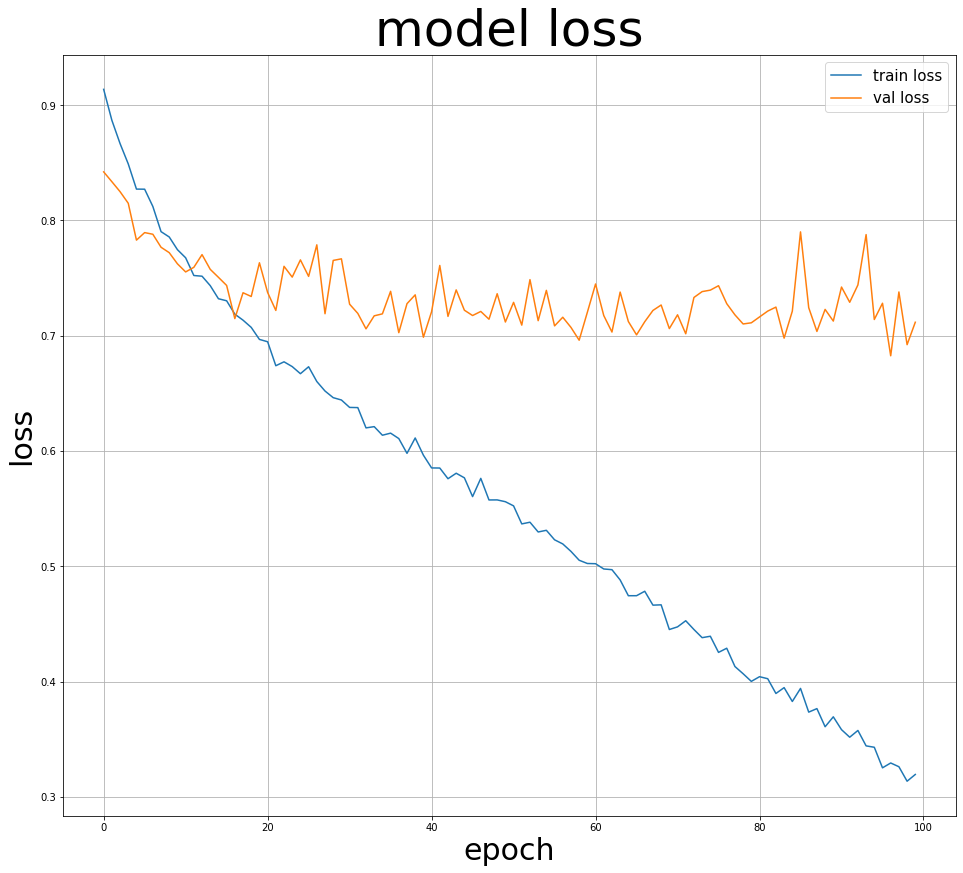

In [65]:
plt.rcParams["figure.figsize"] = (16,14)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')




plt.title('model loss',size=50)
plt.ylabel('loss',size=30)
plt.xlabel('epoch',size=30)
plt.legend(prop={'size': 15})
plt.grid()

plt.savefig('LossVal_loss2222222.jpg')

plt.show()



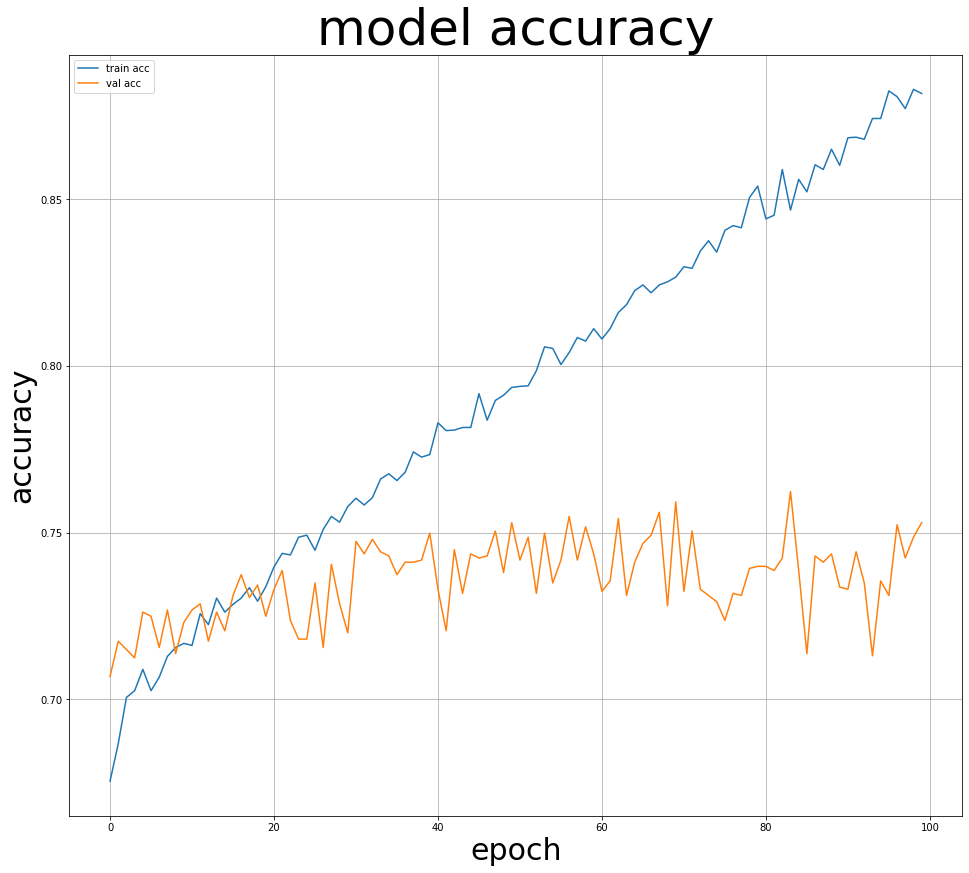

In [66]:
plt.rcParams["figure.figsize"] = (16,14)

plt.rcParams["figure.figsize"] = (16,14)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')


plt.title('model accuracy',size=50)
plt.ylabel('accuracy',size=30)
plt.xlabel('epoch',size=30)
plt.legend(prop={'size': 15})
plt.grid()
plt.legend()
plt.savefig("acc222.jpg")

plt.show()

In [50]:
pred = model.predict(test_df)
pred = np.argmax(pred,axis=1)


In [51]:
from sklearn.metrics import classification_report

print(classification_report(test_labl,pred))

              precision    recall  f1-score   support

           0       0.37      0.36      0.36        81
           1       0.36      0.66      0.47        90
           2       0.55      0.52      0.53       228
           3       0.38      0.11      0.17        28
           4       0.88      0.92      0.90      1328
           5       0.63      0.30      0.41       226
           6       0.53      0.86      0.66        22

    accuracy                           0.76      2003
   macro avg       0.53      0.53      0.50      2003
weighted avg       0.76      0.76      0.75      2003



In [54]:
import sklearn.metrics as metrics

cf_matrix= metrics.confusion_matrix(y_true=test_labl, y_pred=pred)  # shape=(12, 12)
print(cf_matrix)

[[  29   28   15    1    5    3    0]
 [  10   59    7    1   10    1    2]
 [  19   27  118    1   58    5    0]
 [   1   13    2    3    9    0    0]
 [   8   21   34    1 1222   31   11]
 [  12   12   40    1   89   68    4]
 [   0    3    0    0    0    0   19]]


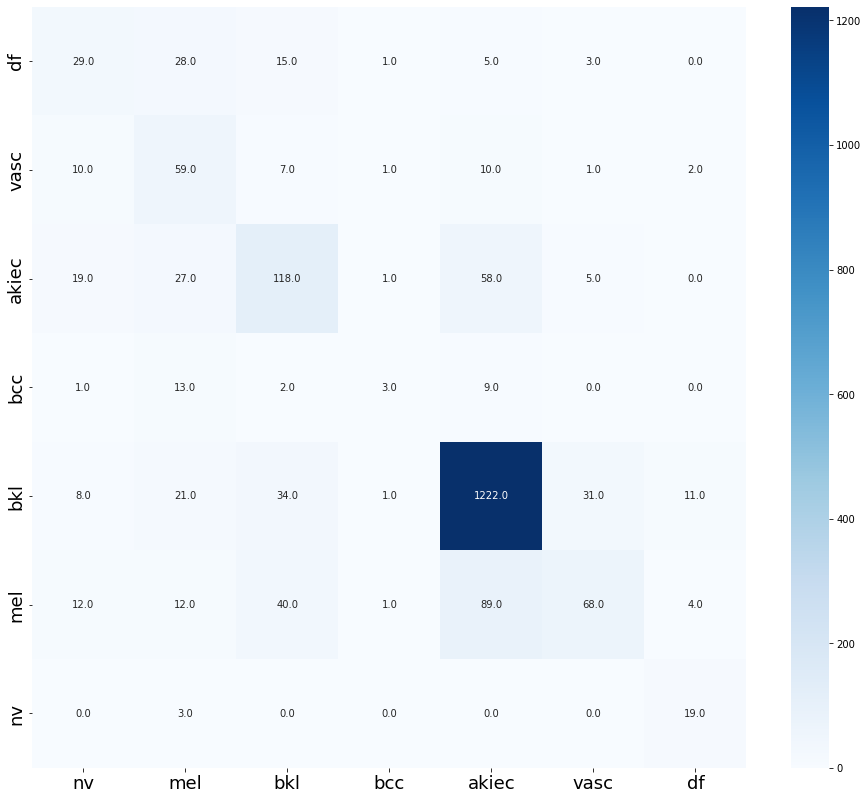

In [67]:
plt.rcParams["figure.figsize"] = (16,14)

import seaborn as sns
ax=sns.heatmap(cf_matrix, annot=True, fmt=".1f",cmap='Blues')

ax.xaxis.set_ticklabels(['nv','mel','bkl','bcc',"akiec","vasc","df"],size=18)
ax.yaxis.set_ticklabels(['df','vasc',"akiec","bcc","bkl","mel","nv"],size=18)

plt.savefig("tuner_cm.jpg")

plt.show()

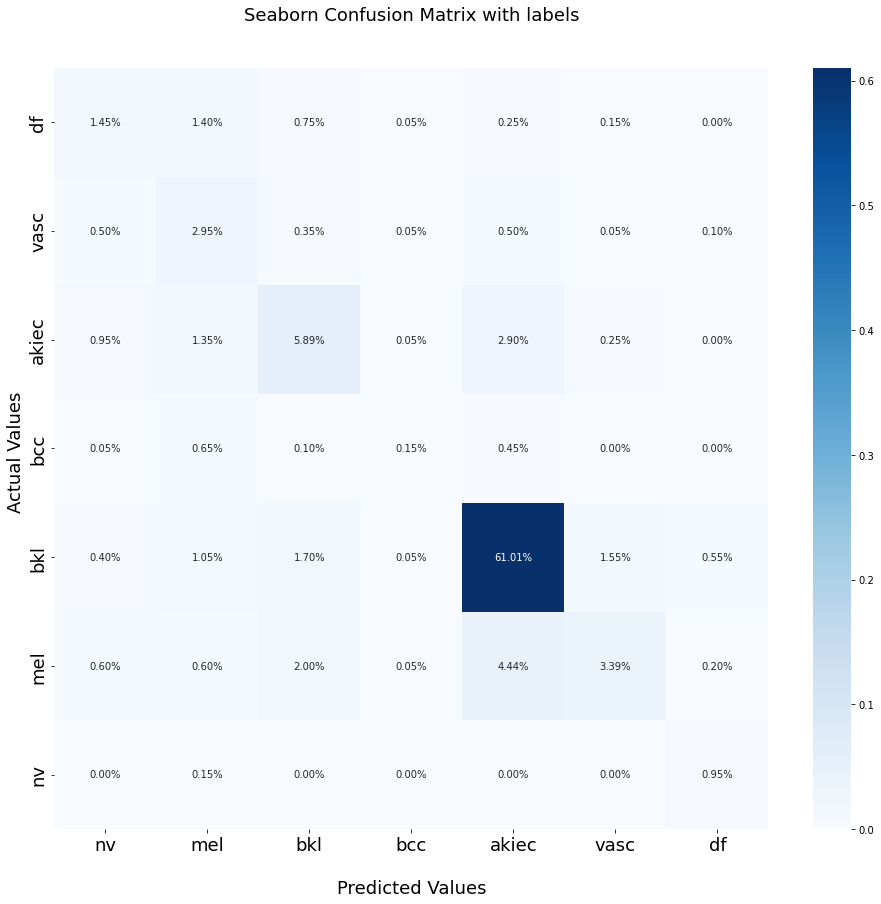

In [68]:
plt.rcParams["figure.figsize"] = (16,14)

ax =sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n',size=18);
ax.set_xlabel('\nPredicted Values',size=18)
ax.set_ylabel('Actual Values ',size=18);


ax.xaxis.set_ticklabels(['nv','mel','bkl','bcc',"akiec","vasc","df"],size=18)
ax.yaxis.set_ticklabels(['df','vasc',"akiec","bcc","bkl","mel","nv"],size=18)
plt.savefig("tuner_cm2.jpg")

plt.show()